# Business objective

To analyze online retail transaction data to identify revenue drivers, customer purchasing patterns, and sales trends, and to provide actionable recommendations to improve revenue, customer retention, and inventory planning.

# Problem Statement

Online retail businesses generate large volumes of transactional data but often fail to convert it into actionable insights.

The key problems addressed:

Which products generate the most revenue?

Who are the most valuable customers?

Which countries contribute most to sales?

How do sales vary over time?

What patterns exist in cancellations and negative quantities?

# Dataset Overview

The dataset contains online retail transaction records, with the following key fields:

InvoiceNo – Unique invoice identifier

StockCode – Product identifier

Description – Product name

Quantity – Number of units purchased

InvoiceDate – Date and time of transaction

UnitPrice – Price per unit

CustomerID – Unique customer identifier

Country – Customer’s country

# Importing libraries & setup the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex

In [2]:
df = pd.read_csv("online_retail_II.csv", parse_dates=['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Quick Dataset Scan

In [3]:
print("Rows :", df.shape[0])
print("Cols :", df.shape[1])

Rows : 1067371
Cols : 8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [5]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [6]:
print("Unique_countries : ",df['Country'].nunique())
print("Unique Customers : ",df['Customer ID'].nunique())
print("Unique Invoice   : ",df['Invoice'].nunique())
print("Unique Stockco   : ",df['StockCode'].nunique())
print("-ve Values count : ",df[df['Quantity']<0].shape[0])

Unique_countries :  43
Unique Customers :  5942
Unique Invoice   :  53628
Unique Stockco   :  5305
-ve Values count :  22950


# Cleaning the dataset

In [7]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [8]:
df['Customer ID'] = df['Customer ID'].astype(str)
df['Customer ID'].dtype

dtype('O')

In [9]:
df['Revenue'] = df['Quantity']*df['Price']

In [10]:
df['Description'] = df['Description'].str.strip()

In [11]:
df['Customer ID'] = df['Customer ID'].replace(['nan', 'NaN', ''], pd.NA)
df['Description'] = df['Description'].replace(['nan', 'NaN', ''], pd.NA)

In [12]:
df['Customer ID'].isna().sum()

243007

In [13]:
df['Description'].isna().sum()

4382

In [14]:
df = df[~df['Description'].isna()]

In [15]:
df.isnull().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    238625
Country             0
Revenue             0
dtype: int64

In [16]:
df = df[~(df['Customer ID'].isna() & (df['Revenue'] == 0) & (df['Price'] == 0))]

In [17]:
fake_des = ['AMAZON FEE','Adjust bad debt', 'Adjustment by Peter on 24/05/2010 1',
            'Adjustment by Peter on Jun 25 2010', 'Adjustment by john on 26/01/2010 16', 
            'Adjustment by john on 26/01/2010 17', 'Bank Charges', 'Manual']
df = df[~df['Description'].isin(fake_des)]

In [18]:
print(df.StockCode.nunique())
print(df.StockCode.value_counts().count())

4925
4925


In [19]:
df['Country'].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland', 'Saudi Arabia',
       'Czech Republic', 'European Community'], dtype=object)

In [20]:
country_to_region = {
    'United Kingdom': 'Europe',
    'France': 'Europe',
    'Belgium': 'Europe',
    'Germany': 'Europe',
    'Portugal': 'Europe',
    'Denmark': 'Europe',
    'Netherlands': 'Europe',
    'Poland': 'Europe',
    'Spain': 'Europe',
    'Italy': 'Europe',
    'Cyprus': 'Europe',
    'Greece': 'Europe',
    'Norway': 'Europe',
    'Austria': 'Europe',
    'Sweden': 'Europe',
    'Finland': 'Europe',
    'Switzerland': 'Europe',
    'Malta': 'Europe',
    'Lithuania': 'Europe',
    'Czech Republic': 'Europe',
    'European Community': 'Europe',
    'Channel Islands': 'Europe',
    'Iceland': 'Europe',
    'EIRE': 'Europe',   # Ireland
    
    'USA': 'North America',
    'Canada': 'North America',
    'Bermuda': 'North America',

    'Japan': 'Asia',
    'Hong Kong': 'Asia',
    'Singapore': 'Asia',
    'Thailand': 'Asia',
    'Korea': 'Asia',

    'Israel': 'Middle East',
    'Lebanon': 'Middle East',
    'Saudi Arabia': 'Middle East',
    'United Arab Emirates': 'Middle East',
    'Bahrain': 'Middle East',
    
    'Australia': 'Oceania',
    
    'Nigeria': 'Africa',
    'RSA': 'Africa',
    
    'Brazil': 'South America',
    
    'West Indies': 'Caribbean',
    
    'Unspecified': 'Unknown'
}


In [21]:
df['Region'] = df['Country'].map(country_to_region)

In [22]:
sorted(df["Region"].unique().tolist())

['Africa',
 'Asia',
 'Caribbean',
 'Europe',
 'Middle East',
 'North America',
 'Oceania',
 'South America',
 'Unknown']

# Creating Sales and Cancellation dataframes separately for analysis

Transactions without CustomerID cannot be used for customer-level analysis and are excluded.

In [34]:
sales = df[(df['Quantity'] > 0)&(df['Price'] > 0)]
sales.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,Region
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,Europe
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,Europe
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,Europe
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,Europe
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,Europe


In [28]:
print("Rows :", sales.shape[0])
print("Cols :", sales.shape[1])

Rows : 1040710
Cols : 10


In [29]:
cancels = df[(df['Quantity']<=0 )& (df['Invoice'].str.contains('C'))]
cancels.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,Region
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.4,Oceania
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,-9.9,Oceania
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,-17.0,Oceania
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,-12.6,Oceania
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.4,Oceania


In [30]:
print("Rows :", cancels.shape[0])
print("Cols :", cancels.shape[1])

Rows : 18819
Cols : 10


# EDA Process

KPI'S ( METRICS )

Revenue represents the actual monetary value generated per transaction line and is used as the primary business metric.

In [27]:
total_revenue = sales['Revenue'].sum()
total_customers = sales['Customer ID'].nunique()
total_orders = sales['Invoice'].nunique()
total_quantity = sales['Quantity'].sum()
avg_order_value = total_revenue / total_orders
cancellation_rate = (cancels['Invoice'].nunique() / total_orders) * 100

print("TOTAL REVENUE      :", total_revenue)
print("TOTAL CUSTOMERS    :", total_customers)
print("TOTAL ORDERS       :", total_orders)
print("TOTAL QUANTITY     :", total_quantity)
print("AVG ORDER VALUE    :", avg_order_value)
print("CANCELLATION RATE  :", cancellation_rate)

TOTAL REVENUE      : 20576628.826999996
TOTAL CUSTOMERS    : 5857
TOTAL ORDERS       : 39698
TOTAL QUANTITY     : 11424918
AVG ORDER VALUE    : 518.3291054209279
CANCELLATION RATE  : 19.529951131039347


# REGION PERFORMANCE ANALYSIS

In [51]:
region_rev = sales[['Region', 'Revenue']]
region_rev.groupby('Region', as_index=False).sum().sort_values(by='Revenue', ascending=False)

,Region,Revenue
3,Europe,2.027155e+07
6,Oceania,1.688347e+05
1,Asia,7.853585e+04
4,Middle East,2.683668e+04
5,North America,1.450219e+04
8,Unknown,1.093601e+04
0,Africa,3.481600e+03
7,South America,1.411870e+03
2,Caribbean,5.364100e+02


In [31]:
sales.groupby('Region')['Revenue'].mean().sort_values(ascending=False)

Region
Oceania          93.278818
Asia             60.458699
Middle East      26.207695
North America    21.645060
Europe           19.588389
Africa           17.854359
South America    15.019894
Unknown          14.542566
Caribbean         9.933519
Name: Revenue, dtype: float64

In [29]:
region_ord = sales[['Region', 'Invoice']]
region_ord.groupby('Region', as_index=False).nunique().sort_values(by='Invoice', ascending=False)

,Region,Invoice
3,Europe,39455
6,Oceania,90
1,Asia,55
4,Middle East,38
5,North America,29
8,Unknown,24
0,Africa,4
7,South America,2
2,Caribbean,1


In [49]:
region_cus = sales[['Region', 'Customer ID']]
region_cus.groupby('Region', as_index=False).nunique().sort_values(by='Customer ID', ascending=False)

,Region,Customer ID
3,Europe,5792
6,Oceania,15
1,Asia,14
5,North America,14
4,Middle East,12
8,Unknown,6
0,Africa,3
7,South America,2
2,Caribbean,1


In [32]:
#revenue per order
rpo = total_orders/total_revenue
#revenue per customer
rpc = total_customers/total_revenue
#Customer Conversion Strength
ccs = total_orders/total_customers

print('Revenue per order            :', rpo)
print('Revenue per customer         :', rpc)
print('Customer Conversion Strength :', ccs)

Revenue per order            : 0.0019292761867731002
Revenue per customer         : 0.0002846433227348997
Customer Conversion Strength : 6.777872631039782


In [33]:
products = sales.groupby('Region')['Description'].value_counts().groupby(level=0).head(5)
products.sort_values(ascending=False)

Region         Description                        
Europe         WHITE HANGING HEART T-LIGHT HOLDER     5765
               REGENCY CAKESTAND 3 TIER               4030
               JUMBO BAG RED RETROSPOT                3380
               ASSORTED COLOUR BIRD ORNAMENT          2933
               PARTY BUNTING                          2723
Oceania        RED TOADSTOOL LED NIGHT LIGHT            13
               DOORMAT UNION FLAG                       12
               LUNCH BAG SPACEBOY DESIGN                12
               LUNCH BAG WOODLAND                       10
               LUNCH BAG RED RETROSPOT                  10
Asia           ROUND SNACK BOXES SET OF 4 FRUITS        10
Middle East    REGENCY CAKESTAND 3 TIER                  8
North America  SET OF 36 TEATIME PAPER DOILIES           8
Asia           RED SPOTTY BISCUIT TIN                    7
               RED RETROSPOT PICNIC BAG                  7
               ASSORTED COLOUR MINI CASES                7
     

# INSIGHTS

 1) Europe region has high contribution to revenue because it has more orders as well as more customers 
2) Caribbean region has low contribution to revenue because it has less orderx as well as less customers this may cause the revenue drop.

# Customer Segmentation: RFM Analysis

In [34]:
# Define snapshot date (1 day after the last invoice date)
snapshot_date = sales['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [35]:
rfm = sales.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice'    : 'nunique', 
    'Revenue'    : 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


Recency → How recently a customer purchased

Frequency → How often they purchase

Monetary → How much revenue they generate

In [36]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

In [37]:
rfm[['R_Score','F_Score','M_Score']].head()

,R_Score,F_Score,M_Score
0,2,5,5
1,5,4,5
2,3,4,4
3,5,3,5
4,2,1,2


In [38]:
rfm['RFM_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

In [39]:
def segment_customer(row):
    score = row['RFM_Score']
    
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 8:
        return 'Potential Loyalist'
    elif score >= 6:
        return 'At Risk'
    else:
        return 'Hibernating'


rfm['Segment'] = rfm.apply(segment_customer, axis=1)

In [40]:
x = rfm['Segment']
y = total_revenue

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


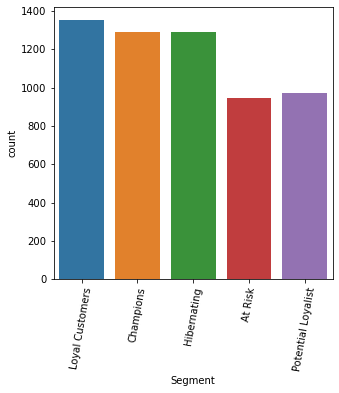

In [41]:
plt.figure(figsize=(5, 5))
plt.xticks(rotation=80)
sns.countplot(x)
plt.show()

In [42]:
# Total Revenue by segment
segment_rev = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
segment_rev

Segment
Champions             1.269628e+07
Loyal Customers       3.124655e+06
Potential Loyalist    9.206396e+05
At Risk               5.226321e+05
Hibernating           3.221513e+05
Name: Monetary, dtype: float64

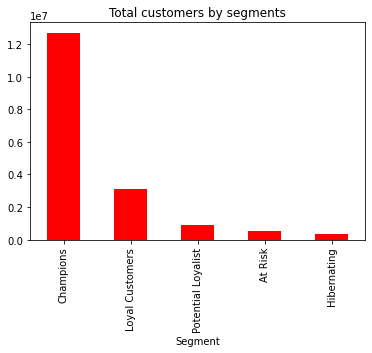

In [43]:
plt.title("Total customers by segments")
segment_rev.plot(kind='bar', color='Red')
plt.show()

In [44]:
#total customers by segment 
tot_cus_seg = rfm['Segment'].value_counts()
tot_cus_seg

Loyal Customers       1352
Hibernating           1293
Champions             1292
Potential Loyalist     973
At Risk                947
Name: Segment, dtype: int64

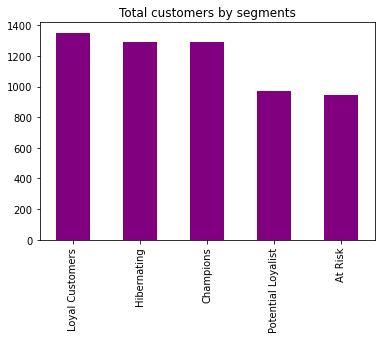

In [45]:
plt.title("Total customers by segments")
tot_cus_seg.plot(kind='bar', color='Purple')
plt.show()

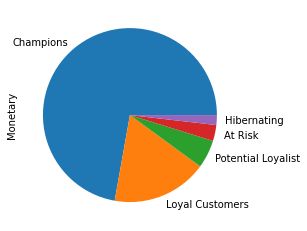

In [46]:
segment_rev.plot(kind='pie')
plt.show()

In [47]:
avg_rfm = rfm.groupby('Segment').agg({
    'Recency'   : 'mean', 
    'Frequency' : 'mean', 
    'Monetary'  : 'mean'
})
avg_rfm.reset_index()

,Segment,Recency,Frequency,Monetary
0,At Risk,258.491024,1.820486,551.881860
1,Champions,25.758514,17.846749,9826.839077
2,Hibernating,457.499613,1.139211,249.150233
3,Loyal Customers,96.373521,5.585799,2311.135366
4,Potential Loyalist,178.769784,3.005139,946.186600


<AxesSubplot:ylabel='Segment'>

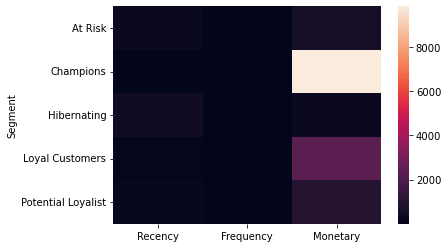

In [48]:
sns.heatmap(avg_rfm)

In [52]:
sales.to_csv("clean_sales.csv", index=False)
cancels.to_csv("clean_cancels.csv", index=False)
rfm.to_csv("rfm_results.csv", index=False)